## Model discrimination via genetic algorithm

Generating training data...
Generating test data...
Running genetic algorithm optimization...
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9894705072124D+01   r2 =  0.5207370570713D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9894705072124D+01   r2 =  0.5207370570713D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9894705072124D+01   r2 =  0.1301842642678D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in abov

/Users/Laura/repo/rEaCt-Retreat-2025/bio_model.py:306: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  y_pred = odeint(



Generation 12
New best fitness: -0.3473148896568877
Parameters: [0.6041954679425426, 4.017659174073625, 3.6804543490902883, 0.4827820560340056, 1.9808944282025434]
Active terms: ['Monod Growth', 'Non-Competitive Product Inhibition']
Errors by experiment: [0.0708894978624911, 0.05332230218379676, 0.052726549548447174, 0.0703765400621527]

Generation 13
New best fitness: -0.2648073943369398
Parameters: [0.6269090075002007, 4.053651408976882, 3.6191109902338754, 0.4314192486300923, 1.17578047543804]
Active terms: ['Monod Growth', 'Non-Competitive Product Inhibition']
Errors by experiment: [0.061444268400789516, 0.03659108593450855, 0.028592199065560743, 0.03817984093608101]

Generation 20 summary:
Best fitness: -0.2648073943369398
Current best parameters: [0.6269090075002007, 4.053651408976882, 3.6191109902338754, 0.4314192486300923, 1.17578047543804]
Current errors by experiment: [0.061444268400789516, 0.03659108593450855, 0.028592199065560743, 0.03817984093608101]

Generation 25
New be

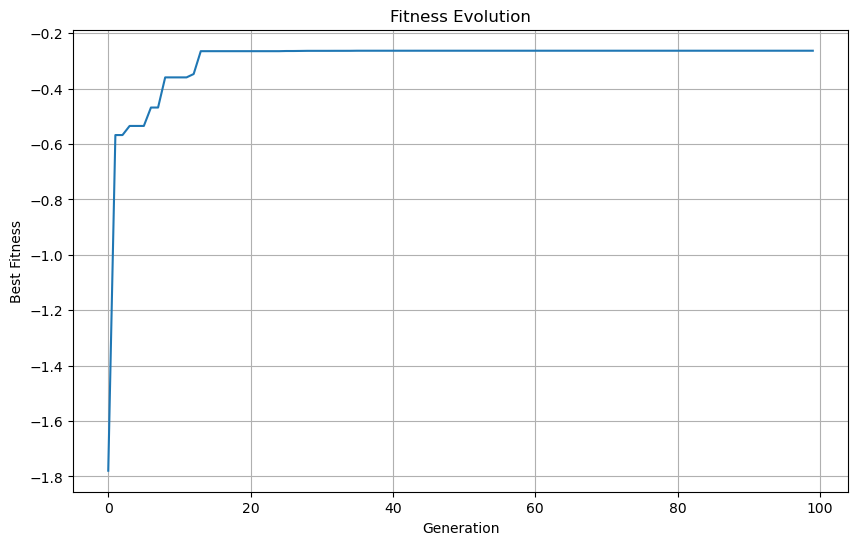

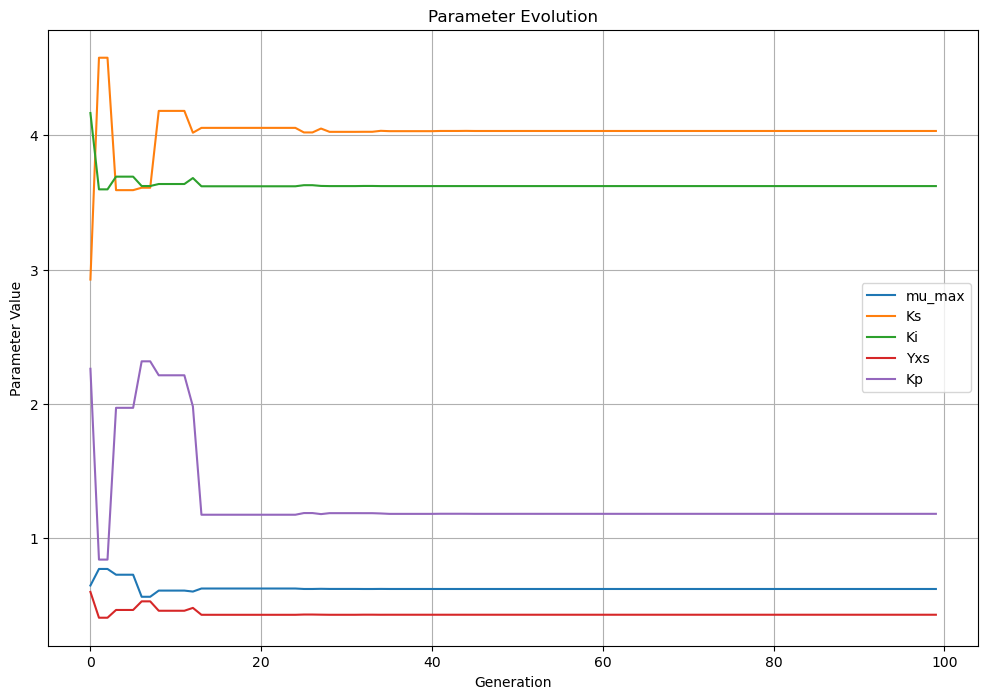


Evaluating solution...

Chosen Terms:
- Monod Growth
- Non-Competitive Product Inhibition

Best Parameters:
mu_max=0.6234421041569582, true value:0.5
Ks=4.030530311833198, true value:2.0
Ki=3.6206239527488138, true value:1.0
Yxs=0.43187560381241563, true value:0.4
KP=1.182529381642355, true value:NaN

Test Data Performance:
Overall RMSE: 0.4215

RMSE by variable:
biomass: 0.3344
substrate: 0.6164
product: 0.1003
inhibitor: 0.0000


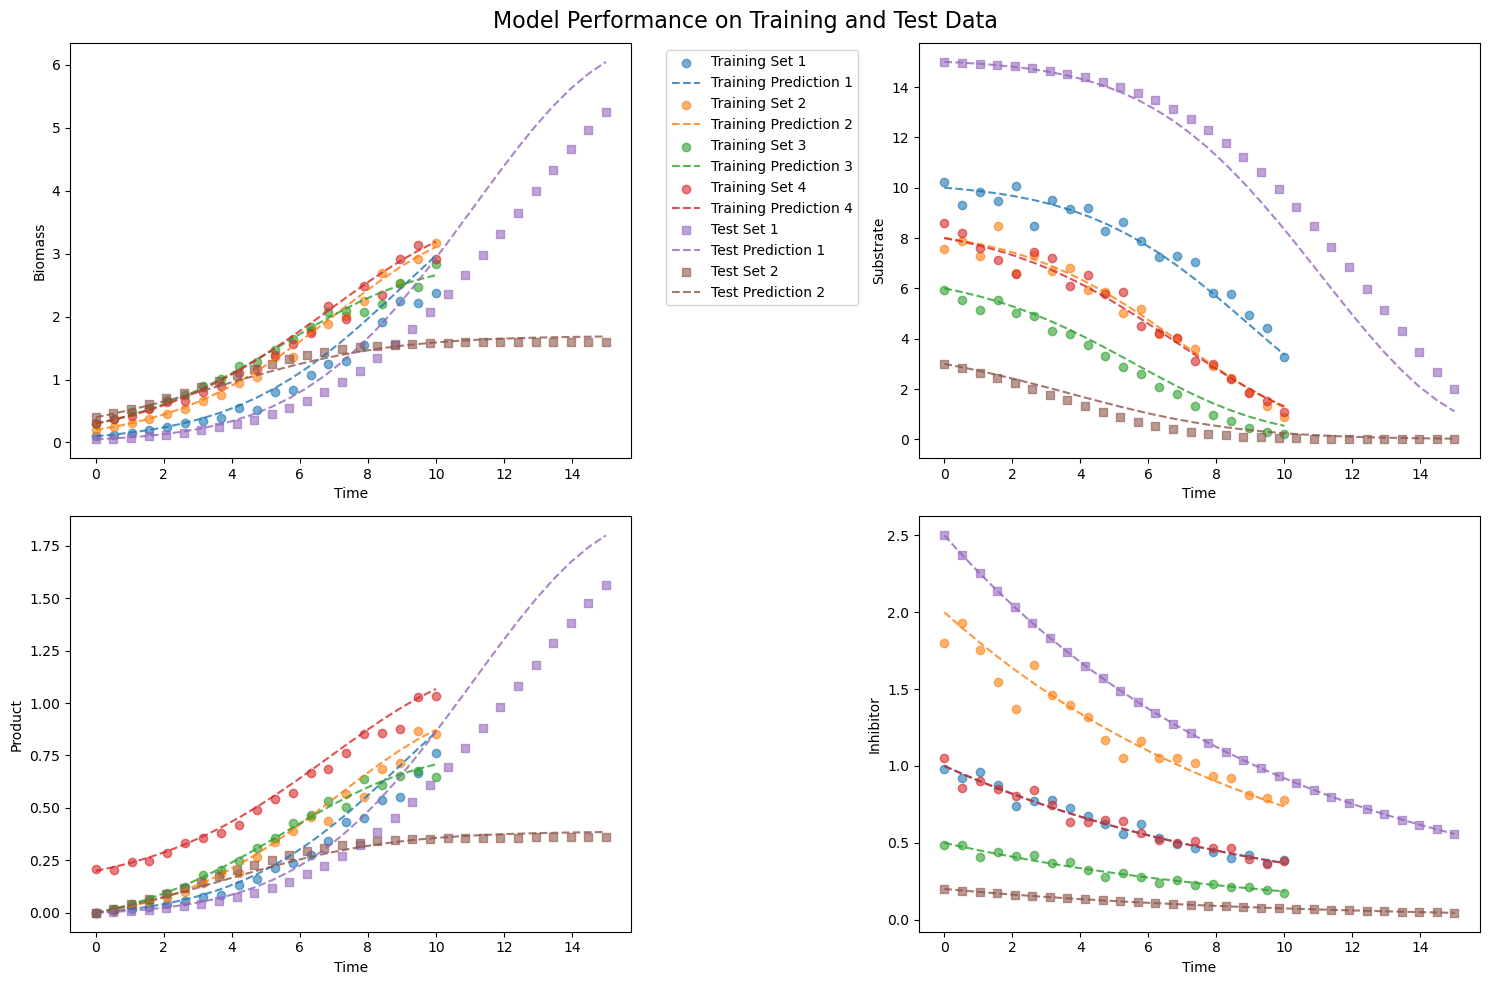

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from bio_model import (
    evaluate_student_solution,
    genetic_algorithm,
    generate_training_data,
    generate_test_data,
    true_model_day2,
    true_model_day3,
    plot_results,
    TERM_NAMES,
)

# Define initial conditions
initial_conditions = [
    [0.1, 10.0, 0.0, 1.0],  # Low X, high S, medium I
    [0.2, 8.0, 0.0, 2.0],   # Medium X, medium S, high I
    [0.3, 6.0, 0.0, 0.5],   # High X, low S, medium I
    [0.3, 8.0, 0.2, 1.0],   # High X, medium S, high I
]

# Generate and save training data
print("Generating training data...")
training_data, training_df = generate_training_data(
    initial_conditions=initial_conditions,
    true_model=true_model_day2,
)

# Generate test data
print("Generating test data...")
test_conditions = [
    [0.05, 15.0, 0.0, 2.5],  # Very low X, very high S
    [0.4, 3.0, 0.0, 0.2],  # Very high X, very low S
]
test_data = generate_test_data(test_conditions=test_conditions, true_model=true_model_day2)

# Run genetic algorithm optimization
print("Running genetic algorithm optimization...")
best_individual = genetic_algorithm(
    training_data,
    population_size=30,
    generations=100
)

# Evaluate solution
print("\nEvaluating solution...")
rmse, variable_rmse, test_predictions = evaluate_student_solution(
    best_individual["mask"],
    best_individual["params"],
    test_data
)

# Print results
print("\nChosen Terms:")
for i, (term, active) in enumerate(zip(TERM_NAMES, best_individual["mask"])):
    if active:
        print(f"- {term}")

print("\nBest Parameters:")
true_values = [0.5, 2.0, 1.0, 0.4, "NaN"]
for param, value, true_value in zip(
    ["mu_max", "Ks", "Ki", "Yxs", "KP"],
    best_individual["params"],
    true_values
):
    print(f"{param}={value}, true value:{true_value}")

print("\nTest Data Performance:")
print(f"Overall RMSE: {rmse:.4f}")
print("\nRMSE by variable:")
for var, error in variable_rmse.items():
    print(f"{var}: {error:.4f}")

# Plot results with enhanced visualization
plot_results(training_data, test_data, best_individual, test_predictions)

Generating training data...
Generating test data...
Running genetic algorithm optimization...

Generation 0
New best fitness: -0.2694742423297844
Parameters: [0.4204554102933219, 2.4902003647070665, 1.9141838507173905, 0.28258473923050653, 3.1451173867892646]
Active terms: ['Substrate Inhibition Factor', 'Substrate Threshold Activation', 'Inhibitor Saturation']
Errors by experiment: [0.08199413359602932, 0.02862968387127799, 0.008850424862477058]

Generation 0 summary:
Best fitness: -0.2694742423297844
Current best parameters: [0.4204554102933219, 2.4902003647070665, 1.9141838507173905, 0.28258473923050653, 3.1451173867892646]
Current errors by experiment: [0.08199413359602932, 0.02862968387127799, 0.008850424862477058]
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  

Generation 4
New best fitness: -0.26045354676579346
Parameters: [0.4935595077248138, 2.481206371407

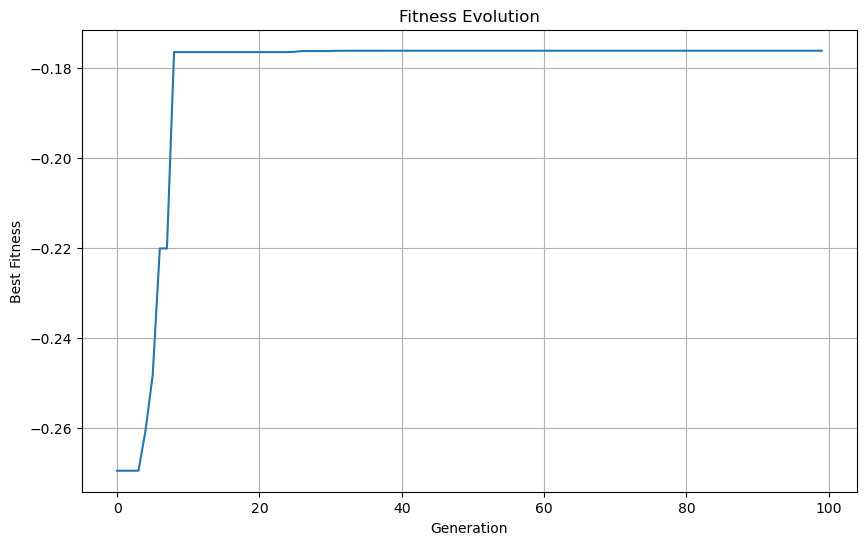

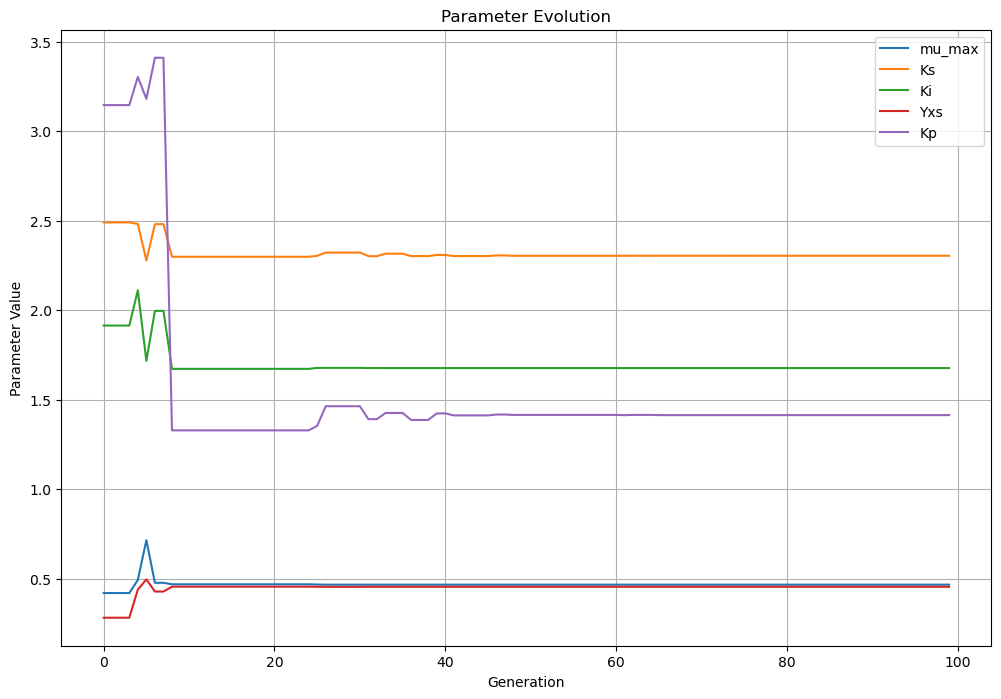


Evaluating solution...
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6266879060156D+01   r2 =  0.4059744930664D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6266879060156D+01   r2 =  0.1014936232666D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6266879060156D+01   r2 =  0.2537340581665D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6266879060156D+01   r2 =  0.2537340581665D-16
 lsoda--  wa

/Users/Laura/repo/rEaCt-Retreat-2025/bio_model.py:643: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  y_pred = odeint(


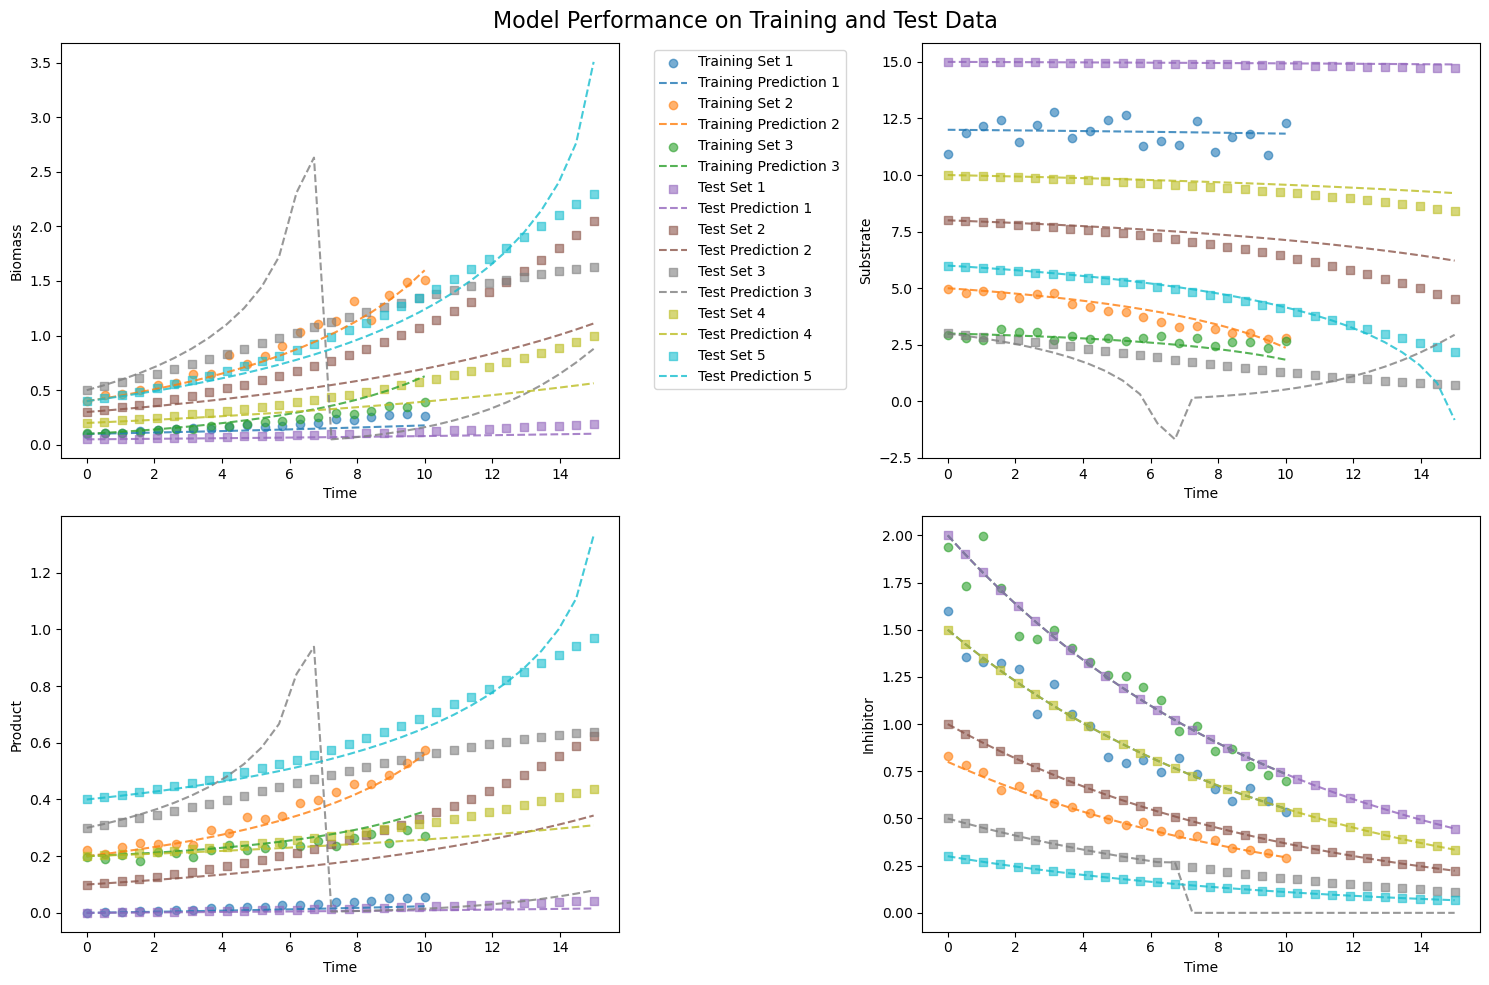

In [2]:
# Generate two training datasets
initial_conditions = [
    [0.1, 12.0, 0.0, 1.5],  # Low X, very high S, medium I
    [0.4, 5.0, 0.2, 0.8],   # High X, medium S, low I
    [0.1, 3.0, 0.2, 2.0],   # Low X, low S, high I
]
    
print("Generating training data...")
training_data, training_df = generate_training_data(
    initial_conditions=initial_conditions,
    true_model=true_model_day3,
    )

# Test conditions (5 different scenarios)
test_conditions = [
    [0.05, 15.0, 0.0, 2.0],  # Very low X, very high S, high I
    [0.3, 8.0, 0.1, 1.0],    # Medium X, high S, medium I
    [0.5, 3.0, 0.3, 0.5],    # High X, low S, low I
    [0.2, 10.0, 0.2, 1.5],   # Low X, high S, medium I
    [0.4, 6.0, 0.4, 0.3],    # High X, medium S, very low I
]

# Generate test data
print("Generating test data...")
test_data = generate_test_data(test_conditions=test_conditions, true_model=true_model_day3)

# Run genetic algorithm optimization
print("Running genetic algorithm optimization...")
best_individual = genetic_algorithm(
    training_data,
    population_size=30,
    generations=100
)

# Evaluate solution
print("\nEvaluating solution...")
rmse, variable_rmse, test_predictions = evaluate_student_solution(
    best_individual["mask"],
    best_individual["params"],
    test_data
)

# Print results
print("\nChosen Terms:")
for i, (term, active) in enumerate(zip(TERM_NAMES, best_individual["mask"])):
    if active:
        print(f"- {term}")

print("\nBest Parameters:")
true_values = [0.8, 3.0, 2.0, 0.5, 1.5]
for param, value, true_value in zip(
    ["mu_max", "Ks", "Ki", "Yxs", "KP"],
    best_individual["params"],
    true_values
):
    print(f"{param}={value}, true value:{true_value}")

print("\nTest Data Performance:")
print(f"Overall RMSE: {rmse:.4f}")
print("\nRMSE by variable:")
for var, error in variable_rmse.items():
    print(f"{var}: {error:.4f}")

# Plot results with enhanced visualization
plot_results(training_data, test_data, best_individual, test_predictions)